In [1]:
%%capture 
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Unet semantic segmentation of Palm Trees in Ahvaz
---
`Credit: Moien Rangzan` -
moienrangzan@gmail.com
 
` Class of RS of Water,Soil and Vegetation 2022  - University of Tehran - Dr. S. Hamze`


In [2]:

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import os
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.layers import Input , Conv2D , MaxPooling2D , Dropout , concatenate , UpSampling2D
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
import numpy as np

from skimage import io

import random

tf version is 2.6.3 (2.8 has a problem with gpu)

In [3]:
print(tf.__version__)

2.6.3


In [4]:
from platform import python_version
print(python_version())

3.7.12


## enabling GPU:

In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2022-07-18 12:25:35.001694: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-18 12:25:35.082513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 12:25:35.199114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 12:25:35.200227: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## An important note about how files should be named
so first we named files like `['1.png','2.png',...] ` but there was a problem
what do you think comes firs? `8.png` or `123.png`? well they are strings so (i know its wierd) but its like `'8something' and '1something'` well 1 comes first and that everything complicated so we remnamed everythin like: this and used `.zfill(3)` to do this: `001.png 002.png ... 300.png`

# Image pipe-line for Keras
since our data is very huge, we can't load it on ram
so we need to use keras image generator for image pipleline

[Semantic Segmentation of Landcover Dataset using U-Net](https://www.youtube.com/watch?v=0W6MKZqSke8&ab_channel=DigitalSreeni)

explains it well, but I use `skimage.io` insted of `cv2` becuase I have RGB images and cv2 changes them to BGR so I have to convert them back
but with io theres no need for this.

another thing is Sreeni uses arg_max for images, I dont need it since I load mask as a 2d np array.

using .sort() is important otherwise, will resulats in unmatched image adn masks.

In [6]:
train_img_dir = "../input/palm-imgen-format/data/train_images/train/"
train_mask_dir = "../input/palm-imgen-format/data/train_masks/train/"

img_list = os.listdir(train_img_dir)
img_list.sort()
msk_list = os.listdir(train_mask_dir)
msk_list.sort()
num_images = len(os.listdir(train_img_dir))
print(num_images)

4388


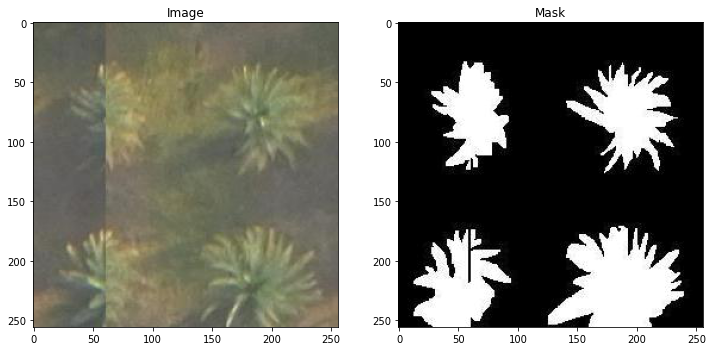

In [7]:
img_num = random.randint(0, num_images-1)

img_for_plot = io.imread(train_img_dir+img_list[img_num])

mask_for_plot =io.imread(train_mask_dir+msk_list[img_num])

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

### .jpg wrong output

my images are `unit8` and in `.jpg` format. we know that jpeg compresses images, so when we load masks as numpy array there are some pixels that are not, 0 nor 255 and were created in the decopression process.

to resolve that we use `preprocess_data` to use thresholidn to remove them.

In [8]:
seed=24
batch_size= 16
# n_classes=4

#Use this to preprocess input for transfer learning


### no augmentation
I dont use `ImageDataGenerator` augmentation abilites becuase Sreeni said, they will create none 0 nor 255 pixel values, and since he was working on multi class unet that would cause a problem, but now that I wrote,`preprocess_data` and I only have one class, I know I could have used this Augmenting ability to created augmented data on the fly instead of scripts on my laptop. -**cnosider this for the next project**

my train project already consists of augmented data, that is hard copied the in the folder.


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

done!


In [10]:
train_img_path = "../input/palm-imgen-format/data/train_images/"
train_mask_path = "../input/palm-imgen-format/data/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, batch_size, seed)

val_img_path = "../input/palm-imgen-format/data/val_images/"
val_mask_path = "../input/palm-imgen-format/data/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, batch_size, seed)

#Make sure the generator is working and that images and masks are indeed lined up. 
#Verify generator.... In python 3 next() is renamed as __next__()

Found 4388 images belonging to 1 classes.
Found 4388 images belonging to 1 classes.


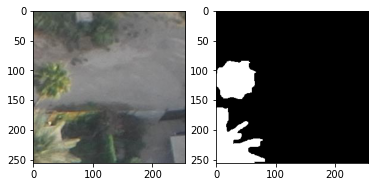

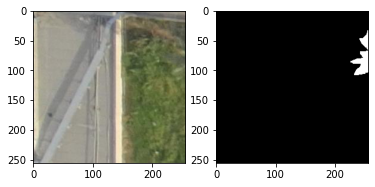

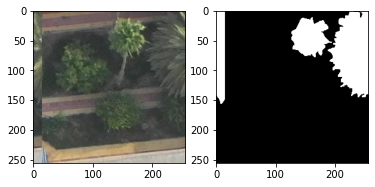

Found 90 images belonging to 1 classes.
Found 90 images belonging to 1 classes.


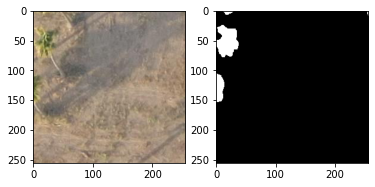

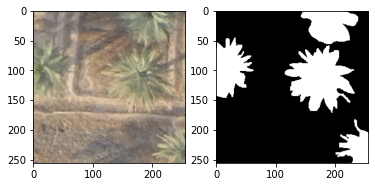

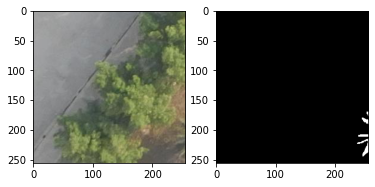

In [11]:
x, y = train_img_gen.__next__()

for i in range(0,3):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

x_val, y_val = val_img_gen.__next__()

for i in range(0,3):
    image = x_val[i]
    mask = y_val[i]
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask*255, cmap='gray')
    plt.show()


In [12]:
#Define the model metrcis and load model. 

num_train_imgs = len(os.listdir('../input/palm-imgen-format/data/train_images/train/'))
num_val_images = len(os.listdir('../input/palm-imgen-format/data/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

print(steps_per_epoch,val_steps_per_epoch)

IMG_HEIGHT =255
IMG_WIDTH  =255
IMG_CHANNELS =3


274 5


# **UNET Architucre**
well it is a U-Net CNN theres nothing to explain :|

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.layers import Input , Conv2D , MaxPooling2D , Dropout , concatenate , UpSampling2D
from tensorflow.keras.layers import Dense, Reshape,Flatten
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
import numpy as np
print('done!')

done!


##### UNET CODE

# **UNET Train**

## Instantiation the Model for our 128x128 image dataset

In [ ]:
from model import UNet

In [15]:
model = UNet((256,256,3))
print('done!')

2022-07-18 12:25:45.030539: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 12:25:45.031722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 12:25:45.032728: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 12:25:45.033857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 12:25:45.034888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

done!


In [16]:
model.summary()

Model: "UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________________

## Showing model Summery

In [17]:
#tf.keras.utils.plot_model(model, show_shapes=True)

## Training the model
our `callbacks` in each epoch if the `metrics` is better than before it saves the model.
`metrics` I belive its criterion that `callbacks.ModelCheckpoint()` use to determine the best, so if `accurisy` goes up it saves the model, we probably can chenge it to `loss` or` val_loss`

we also save the last checkpoint after the training is done as: `Unet_FT_LastEpoc100.h5`

uncomment two cells blew when you wnat to train the data, otherwise we are using an **.h5** that we trained before  to load our model.

In [18]:
#callbacks=[keras.callbacks.ModelCheckpoint('Unet_FT_best.h5',save_best_only=True)]


model.compile(optimizer = optimizers.Adam(1e-4) , 
              loss = losses.BinaryCrossentropy(from_logits = False),
              metrics = ['accuracy'])

history = model.fit(train_img_gen,
                      steps_per_epoch=steps_per_epoch,
                      epochs=50,
                      verbose=1,
                      validation_data=val_img_gen,
                      validation_steps=val_steps_per_epoch)

# history = model.fit(train_img_gen,y_train , 
#                     batch_size = BATCH_SIZE,
#                     epochs = EPOCHS  ,
#                     validation_data = VAL_DATA , verbose = 1)

model.save("Unet_FT_LastEpoc50.h5")

2022-07-18 12:25:47.034235: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-07-18 12:25:49.828994: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


274/274 [==============================] - 57s 170ms/step - loss: 0.6880 - accuracy: 0.8822 - val_loss: 0.6824 - val_accuracy: 0.8957
Epoch 2/50
274/274 [==============================] - 28s 103ms/step - loss: 0.6776 - accuracy: 0.8875 - val_loss: 0.6720 - val_accuracy: 0.8967
Epoch 3/50
274/274 [==============================] - 27s 99ms/step - loss: 0.6675 - accuracy: 0.8876 - val_loss: 0.6615 - val_accuracy: 0.9002
Epoch 4/50
274/274 [==============================] - 27s 98ms/step - loss: 0.6577 - accuracy: 0.8876 - val_loss: 0.6516 - val_accuracy: 0.8989
Epoch 5/50
274/274 [==============================] - 27s 98ms/step - loss: 0.6481 - accuracy: 0.8875 - val_loss: 0.6428 - val_accuracy: 0.8920
Epoch 6/50
274/274 [==============================] - 28s 102ms/step - loss: 0.6387 - accuracy: 0.8879 - val_loss: 0.6312 - val_accuracy: 0.9059
Epoch 7/50
274/274 [==============================] - 28s 102ms/step - loss: 0.6296 - accuracy: 0.8875 - val_loss: 0.6243 - val_accuracy: 0.8918

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


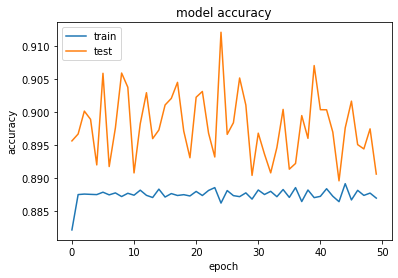

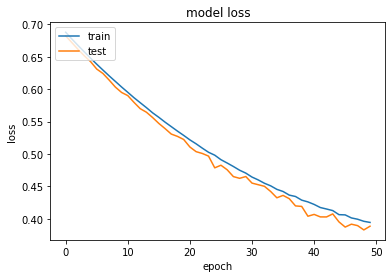

In [19]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

I used to use the code below to save the model from working to drive when i was coding in colab:

In [20]:
# !cp -r "/content/Unet_FT_LastEpoc100.h5" "/content/drive/MyDrive/pureUnet_100ep_CT_v2.h5"

# Analysing the the model and its predictions
we feed the model our test images and we see it return s 60(the same as input) predicted masks

### Notice
Notice that we loaded the model from drive, `if you ran the training cell` make sure to `comment out the cell blew` so it dont override your model

you need upload a new trained model or like below load the model I already uploeaded on kaggle using 'add data'

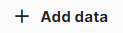

In [21]:
# model = keras.models.load_model("../input/pure-unet-trained-100ep-on-ct2/pure_unet_ct2.h5")
# print('model imported!')

checking model size:

In [22]:
# ! du -sh ../input/pure-unet-trained-100ep-on-ct2/pure_unet_ct2.h5

In [23]:
# predicts=model.predict(test_images)
# print(predicts.shape)

## Visualizaing the data:


In [24]:
test_image_batch, test_mask_batch = val_img_gen.__next__()
test_pred_batch = model.predict(test_image_batch)

In [25]:
print(test_pred_batch.shape)

(16, 256, 256, 1)


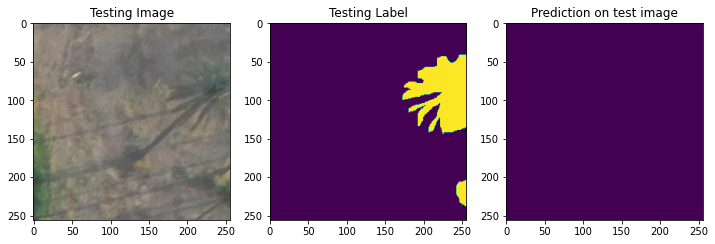

In [26]:
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch[img_num])
plt.show()

In [27]:
!pip freeze > requirements.txt

## Saving the plots of real vs predicted masks:
this is the code above looping through all predictions, and instead of showing them we are closing all plots after each loop so it wont consume RAM

In [28]:
# if not (os.path.exists("./figs")):
#   os.makedirs('./figs')
# else:
#   print('path exists')

# for samplenumber in range(572):

#     fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
#     plt.rcParams['figure.figsize'] = [20,5]
#     fig.suptitle('Comparing the Unet Result with input data - Test img number: '+str(samplenumber))
#     ax1.imshow(test_images[samplenumber,:,:,0])
#     ax1.set_title('Input FT')
#     ax2.imshow(test_labels[samplenumber,:,:,0])
#     ax2.set_title('Real Mask')
#     ax3.imshow(predicts[samplenumber,:,:,0])
#     ax3.set_title('UNET Predicted Mask')
#     plt.savefig('./figs/'+str(samplenumber)+'.png')
#     plt.close()
#     if samplenumber%50==0:
#         print(str(samplenumber)+'/'+'572')


zipping the folder we created so we can downlaod it:

In [29]:
# import shutil
# shutil.make_archive('figs', 'zip', './figs/')

## Saving predicted masks
Sacing all the prediction masks (we multiply it by 255 becasue we want to save it as png)

In [30]:
# if not (os.path.exists("./predicts")):
#   os.makedirs('./predicts')
# else:
#   print('path exists')

# for samplenumber in range(572):
#     pred = predicts[samplenumber,:,:,0]
#     pred = pred*255
#     cv.imwrite('./predicts/'+str(samplenumber)+'.png',pred)
#     if samplenumber%50==0:
#         print(str(samplenumber)+'/'+'572')

# import shutil
# shutil.make_archive('predicts', 'zip', './predicts/')

# Watching the Reualts in Action:
So in `orig_noisy_test_images` we have the 572 images that where used to create `test_images` (which are their Fourier Transfrom)

In [31]:
# TH = 0.25
# PATH = './thresh0-25'
# all_thresh_masks = (predicts>TH)*1

# if not (os.path.exists(PATH)):
#   os.makedirs(PATH)
# else:
#   print('path exists')



# for samplenumber in range(572):
    
#     fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
#     plt.rcParams['figure.figsize'] = [20,5]
#     fig.suptitle('img '+str(samplenumber)+' Threshold Evaluation - ' + str(TH))
#     ax1.imshow(test_images[samplenumber,:,:,0])
#     ax1.set_title('input FT')
#     ax2.imshow(predicts[samplenumber,:,:,0])
#     ax2.set_title('UNET Predicted Mask')
#     ax3.imshow(all_thresh_masks[samplenumber,:,:,0])
#     ax3.set_title('UNET Predicted Mask after Threshold')
#     plt.savefig(PATH +'/'+str(samplenumber)+'.png')
#     plt.close()
#     if samplenumber%50==0:
#         print(str(samplenumber)+'/'+'572')
# import shutil
# shutil.make_archive('th0-25', 'zip', PATH+'/')
# print('done!')